# ENEM: Analyzing data from 1999 to 2008
_by Lucas Bracher_

ENEM, Brazilian National High School Exam, was in its first 11 years an evaluation tool for Brazilian high school. At the end of this period, it became a compulsory examination for anyone who wanted to enter federal colleges and universities, that is, it became an examination similar to the Italian *Esame di Maturità* and the French *Baccalauréat*. Fortunately, Brazilian Ministry of Education made available the scores and socioeconomic data of each candidate, so that we can make very interesting data crossings of these first 10 years, as well as discover relationships between candidates' grades with family income, presence of tap water and electricity in house, as well as the relation between the scores and the studies in public or private school and its relation with concomitant work during high school. In this article we'll look at these files with the [Pandas](https://pandas.pydata.org/), [NumPy](http://www.numpy.org/) and [Matplotlib](https://matplotlib.org /) libraries.

## Getting the data

The data can be downloaded from the [INEP website](http://inep.gov.br/microdados), institute responsible for the elaboration, application and organization of the results. All data available up to March 14, 2019 goes from the first edition (1998) until 2017. Unfortunately, because few students answered to the socio-economic evaluation of the 1998 edition, we decided not to use the data from this edition. Therefore, we used the data from 1999 to 2008. From 2009 the data became available in a slightly more complex format and we thought it would be better to analyze them in a second moment.

The data for each of these first years are made available in `.sas` and` .sps` format, which are data description files, related to another text file with fixed width fields.

## Analysis of the content of each year and preparation of the data

In general, each set of data for each year is made available in a `.zip` file containing the following directories:

* `DATA`: contains a` .txt` file containing the notes and socio-economic data of each student. This file is in fixed width field format.
* `INPUT_SAS_SPSS`: contains the metadata files for reading the` .txt` file contained in `DATA`.
* `README `: contains a` .pdf` extension file containing the data dictionary for reading the `.txt` file, as well as the contents of the tests.

For the use of the data of each year, the `.txt` and` .sas` files of each year were placed in the same folder. Each `.sas` file was edited so that the` .txt` file could be read while it was in the same folder, because originally the required path is `C: \`.

## First problems

The first problem we faced was that the `.sas` files could not be read with the package sas made available in Python:



```python
import pandas as pd
enem1998 = pd.read_sas("INPUT_SAS_ENEM_1998.sas")

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-1-c40e8ad19bdf> in <module>
      1 import pandas as pd
      2 
----> 3 enem1998 = pd.read_sas("INPUT_SAS_ENEM_1998.sas")

~/.local/lib/python3.6/site-packages/pandas/io/sas/sasreader.py in read_sas(filepath_or_buffer, format, index, encoding, chunksize, iterator)
     46             format = "sas7bdat"
     47         else:
---> 48             raise ValueError("unable to infer format of SAS file")
     49 
     50     if format.lower() == 'xport':

ValueError: unable to infer format of SAS file
```


The second problem is the inconsistency of fields and data over the years. There are several fields in the data of each year whose names have no clear meaning; each year such fields have different names, different positions and different contents, apart from the fact that the Pandas `.csv` file parser sometimes does not make a good guess of which would be the best type for each column, resulting a DataFrame of much larger size than necessary.

## Solutions

The solution found for the first problem was to write a quick "parser" based on .sas files. To build this parser, we opened an .sas file and we got the following in the first few lines:

```
DATE ENEM_1998;
RETAIN MASC_INSCRITO NU_ANO DT_NASCIMENTO;
INFILE "C: \ DATA_ENEM_1998.TXT"
LRECL = 477 MISSOVER;
INPUT
@1 MASC_INSCRITO $ Char8. / * Enrollment Mask * /
@9 NU_ANO 8. / * Year of the Enem * /
@17 DT_NASCIMENTO $ Char20. / * Date of birth of the registrant * /
@37 TP_SEXO 8. / * Sex of member * /
@45 CODMUNIC_INSC $ Char12. / * Municipal Code in which the enrollee lives: * /
.
.
.
```

From these files a quick parser was written, and it will be presented just below.

The solution to the second problem was to construct a metadata table containing the information of each field in each year in order to normalize both column names and contents. This table contains 6 fields:

* `YEAR`: year of the ENEM test

* `FIELD`: field of ENEM data year file

* `TYPE`: type to be converted to reading `.csv` file

* `RENAME_TO`: significant name for which the field will be renamed

* `MANDATORY`: If this field is set to 1, only records containing this field will be loaded.

* `CONVERT_TO`: data conversion dictionary for more meaningful content.

Such a table was written to a `.csv` file and loaded using Pandas itself.


## Downloading and processing data data (optional step)

This step is optional and can last several hours of processing and can be skipped. You can go to the [Fast Data Loading](#Fast-data-loading) part, where data is loaded from a binary file in a few seconds.

In order to download the data from the internet and make it into `.csv` files, just run the code below:

In [1]:
import collections
import csv, io, zipfile
import requests
import re
import sys, os, shutil
from IPython.display import display
import ipywidgets as widgets

out = widgets.HTML(value='',
    placeholder='',
    description='')
display(out)

urlprefix = 'http://download.inep.gov.br/microdados/'

files = {
    'micro_enem1999.zip' : 
        {'meta' : 'IMPUT_SAS_SPSS/INPUT_SAS_ENEM_1999.sas', 
         'data' : 'DADOS/DADOS_ENEM_1999.zip', 
         'rename' : 'DADOS_ENEM_1999.csv'},
    'micro_enem2000.zip' : 
        {'meta' : 'IMPUT_SAS_SPSS/INPUT_SAS_ENEM_2000.sas',
         'data' : 'DADOS/DADOS_ENEM_2000.zip', 
         'rename' : 'DADOS_ENEM_2000.csv'},
    'micro_enem2001.zip' : 
        {'meta' : 'IMPUT_SAS_SPSS/INPUT_SAS_ENEM_2001.sas',
         'data' : 'DADOS/DADOS_ENEM_2001.TXT', 
         'rename' : 'DADOS_ENEM_2001.csv'},
    'micro_enem2002.zip' : 
        {'meta' : 'INPUTS_SAS_SPSS/INPUT_SAS_ENEM_2002.sas',
         'data' : 'DADOS/DADOS_ENEM_2002.zip', 
         'rename' : 'DADOS_ENEM_2002.csv'},
    'micro_enem2003.zip' : 
        {'meta' : 'INPUTS_SAS_SPSS/INPUT_SAS_ENEM_2003.sas',
         'data' : 'DADOS/DADOS_ENEM_2003.zip', 
         'rename' : 'DADOS_ENEM_2003.csv'},
    'micro_enem2004.zip' : 
        {'meta' : 'INPUTS_SAS_SPSS/INPUT_SAS_ENEM_2004.sas',
         'data' : 'DADOS/DADOS_ENEM_2004.zip', 
         'rename' : 'DADOS_ENEM_2004.csv'},
    'microdados_enem_2005.zip' : 
        {'meta' : 'INPUT_SAS_ENEM_2005.sas',
         'data' : 'DADOS_ENEM_2005.zip', 
         'rename' : 'DADOS_ENEM_2005.csv'},
    'microdados_ENEM_2006.zip' : 
        {'meta' : '',
         'data' : 'Microdados Enem 2006 (2° Ediç╞o)/Dados/MICRODADOS_ENEM_2006.csv', 
         'rename' : 'DADOS_ENEM_2006.csv'},
    'microdados_enem_2007_DVD.zip' : 
        {'meta' : '',
         'data' : 'Microdados Enem 2007 (2° Ediç╞o)/Dados/MICRODADOS_ENEM_2007.csv', 
         'rename' : 'DADOS_ENEM_2007.csv'},
    'microdados_enem_2008.zip' : 
        {'meta' : '',
         'data' : 'Microdados Enem 2008 (2° Ediç╞o)/Dados/MICRODADOS_ENEM_2008.csv', 
         'rename' : 'DADOS_ENEM_2008.csv'}
}

def transform_sas_to_csv(sas_filename):

    dir_name = os.path.split(sas_filename)[0]
    csv_filename = ""
    
    pre_fields = collections.OrderedDict()

    # get info from malformed sas file
    try:
        sas_file = open(sas_filename, "r", encoding="ISO-8859-1")
    except:
        sys.exit("File not found")
    for line in sas_file:
        match = re.search('^INFILE.*', line)
        if match:
            data_filename = os.path.join(dir_name, line.split('"')[1].split('\\')[-1])
            csv_filename = "{}.csv".format(data_filename)
        match = re.search('^@([0-9]+)[ \t]+([^ \t]+)', line)
        if match:
            pre_fields[match.group(2)] = int(match.group(1))-1
    pre_fields['ending'] = None
    sas_file.close()

    # post-processing fields
    pre_value = None
    pre_key = None
    fields = collections.OrderedDict()
    for key, value in pre_fields.items():
        if pre_key:
            fields[pre_key] = [pre_value, value]
        pre_value = value
        pre_key = key

    # open csv file to write
    csv_file = open(csv_filename, mode='w')
    fieldnames = list(fields.keys())
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=";")
    writer.writeheader()

    # open data file
    try:
        data_file = open(data_filename, "r", encoding="ISO-8859-1")
        out.value = "Data file opened"
    except:
        return ""
    n = 1
    for line in data_file:
        # read data file line by line
        csv_line = dict()
        for k, v in fields.items():
            csv_line[k] = str.strip(line[v[0]: v[1]])
        writer.writerow(csv_line)
        if n % 1000 == 0:
            out.value = "Reading line {}".format(n)
        n += 1
    
    csv_file.close()
    data_file.close()
    return csv_filename
    

for zipname, zipcompressedfiles in files.items():
    data = zipcompressedfiles['data']
    meta = zipcompressedfiles['meta']
    rename = zipcompressedfiles['rename']
    
    out.value = "Downloading {}".format(zipname)
    enem = requests.get("{}{}".format(urlprefix,zipname))
    z = zipfile.ZipFile(io.BytesIO(enem.content))
    z.extract(data, path='tmp')
    
    if meta:
        z.extract(meta, path='tmp')
        if '.zip' in data:
            z = zipfile.ZipFile(os.path.join('tmp', data))
            z.extractall(path='tmp')
            data = z.namelist()[0]
            
        os.rename(os.path.join('tmp', data), os.path.join('raw', os.path.basename(data)))
        os.rename(os.path.join('tmp', meta), os.path.join('raw', os.path.basename(meta)))
        csv_name = transform_sas_to_csv(os.path.join('raw', os.path.basename(meta)))
        os.rename(csv_name, os.path.join('data', rename))
    else:
        os.rename(os.path.join('tmp', data), os.path.join('data', rename))
    out.value = "{} finished.".format(os.path.basename(data))
out.value = "All data downloaded and processed."


HTML(value='', placeholder='')

Then, it is necessary to load the data dictionary, already described above:

In [2]:
import pandas as pd
dicts = pd.read_csv("table_of_dicts_enem.csv", delimiter='\t')
dicts.dropna(subset=['CONVERT_TO']).head()

,YEAR,FIELD,TYPE,RENAME_TO,MANDATORY,CONVERT_TO
19,1999,Q3,category,SKIN_COLOR,NaN,"{'A': 'white', 'B': 'biracial', 'C': 'black', ..."
23,1999,Q18,category,FATHER_SCHOOLING,NaN,"{'A': 'A-didnt_go_to_school', 'B': 'B-primary_..."
24,1999,Q19,category,MOTHER_SCHOOLING,NaN,"{'A': 'A-didnt_go_to_school', 'B': 'B-primary_..."
26,1999,Q55,category,SECONDARY_SCHOOL_1,1.0,"{'A': 'daytime', 'B': 'both', 'C': 'nighttime'}"
27,1999,Q56,category,SECONDARY_SCHOOL_2,1.0,"{'A': 'public', 'B': 'both', 'C': 'private'}"


## Loading data (optional step)

The data was uploaded to a single DataFrame. To facilitate analysis on a conventional computer, a maximum of 100000 rows per year were considered. Obviously, if you have a computer with a lot of memory, we encourage you to raise that level to 200,000 or more, but we believe that the statistical effect will not be so impacting in the analysis.

One important thing to note is that the encoding of files is different. Files from 1999 to 2005 are encoded in `utf-8` whereas those from 2006 to 2008 are encoded in` latin1`.

In [3]:
import ast
import os
import time
from IPython.display import display
import ipywidgets as widgets

out = widgets.HTML(value='',
    placeholder='',
    description='')
display(out)

start_time = time.time()

enem = pd.DataFrame()

files = {
    1999 : 'utf-8', 2000 : 'utf-8', 2001 : 'utf-8', 2002 : 'utf-8', 2003 : 'utf-8', 
    2004 : 'utf-8', 2005 : 'utf-8', 2006 : 'latin1', 2007 : 'latin1', 2008 : 'latin1' 
}

for year, enc in files.items():
    # Which columns we would like to load for this year
    columns = list(dicts.loc[dicts['YEAR']==year , 'FIELD'])
    # Which types are they?
    types = dicts.loc[dicts['YEAR']==year, ['FIELD', 'TYPE']].\
        dropna().set_index('FIELD').squeeze().to_dict()
    # Only non-NaN fields:
    mandatory = list(dicts.loc[(dicts['YEAR']==year) & (dicts['MANDATORY']==1) , 'FIELD'])
    out.value = "Loading DADOS_ENEM_{}.csv...".format(year)
    
    enem_year = pd.read_csv(os.path.join("data", 'DADOS_ENEM_{}.csv'.format(year)), 
        delimiter=';', 
        usecols=columns,
        dtype=types,
        encoding=enc
    ).dropna(
        subset=mandatory
    )
    
    # Which will be the new names of the fields?
    new_names = dicts.loc[dicts['YEAR']==year, ['FIELD', 'RENAME_TO']].\
        dropna().set_index('FIELD').squeeze().to_dict()
    
    enem_year.rename(
        index=str, 
        columns=new_names, 
        inplace=True)
    
    # Sampling down to 100000
    if len(enem_year) > 100000:
        enem_year = enem_year.sample(n = 100000)
    
    # Changing fields contents:
    new_values = dicts.loc[dicts['YEAR']==year, ['RENAME_TO', 'CONVERT_TO']].dropna()
    
    for index, row in new_values.iterrows():
        # Converting string representation of a dict to a real dict (be careful and 
        #   check csv file before running!)
        d = ast.literal_eval(row[1])
        enem_year[row[0]].replace(d.keys(), d.values(), inplace=True)
        
    # Putting all together
    enem = pd.concat([enem, enem_year], sort=False)
    del enem_year

out.value = "All data loaded in {} seconds.".format(round(time.time() - start_time, 2))

HTML(value='', placeholder='')

Before go on, let's enforce data types:

In [4]:
# First we make a copy of the original field names, new names and their desired types:
ct = dicts[['FIELD', 'RENAME_TO', 'TYPE']].copy()
# If RENAME_TO is empty, we fill with original field name:
ct['RENAME_TO'].fillna(ct['FIELD'], inplace=True)
# Now FIELD needs to be dropped, and RENAME_TO will be renamed to FIELD
ct.drop(columns='FIELD', inplace=True)
ct.columns = ['FIELD', 'TYPE']
# We just drop the rows that have NaN values.
# These field types will be guessed at load time and their types are ok:
ct.dropna(inplace=True)
# We set the index 
ct.set_index('FIELD', inplace=True)
for index, row in ct.iterrows():
    if index in enem.columns:
        enem[index] = enem[index].astype(row[0])

And save DataFrame in an .hdf5 file in order to reload this data as fast as possible:

In [5]:
start_time = time.time()

s = pd.HDFStore('enem.h5')
s.put('enem', enem, format='table', data_columns=True)
s.close()

print("--- {} seconds to save ---".format(round(time.time() - start_time, 2)))

--- 93.55 seconds to save ---


## Fast data loading

The entire previous section can be skipped if you just want to access the results. In the file `enem.h5` are the data of up to 100000 students per year, from the years 1999 to 2008, chosen randomly. Thus, it is possible to skip the slow portion of data load and leave only the part of data analysis and visualization.
To load the data, just enter the following commands:

In [4]:
import pandas as pd
import time
start_time = time.time()

enem = pd.read_hdf('enem.h5', 'enem')

print("--- {} seconds to reload ---".format(round(time.time() - start_time, 2)))

--- 22.55 seconds to reload ---


Data will be loaded from the medium directly into the DataFrame. In tests done on a typical computer, comparison between the load speed of the original .csv files and the .h5 file was 80 to 100 times faster.

## Data analysis

### Difference of grades between public and private schools

Due to profound social problems in Brazil, we think the first interesting analysis is to observe the difference of grades between public and private schools, as well as the standard deviations of these two schools. Let's look at the differences between multiple choice test and essay scores.

First, from the multiple choice test:

In [5]:
ppo_mean = enem.groupby(['YEAR', 'SECONDARY_SCHOOL_2']).mean()['MC_SCORE']
ppo_mean_public = ppo_mean.loc[ppo_mean.index.get_level_values('SECONDARY_SCHOOL_2') == 'public'].xs('public', level=1)
ppo_mean_private = ppo_mean.loc[ppo_mean.index.get_level_values('SECONDARY_SCHOOL_2') == 'private'].xs('private', level=1)

In [6]:
ppo_std = enem.groupby(['YEAR', 'SECONDARY_SCHOOL_2']).std()['MC_SCORE']
ppo_std_public = ppo_std.loc[ppo_std.index.get_level_values('SECONDARY_SCHOOL_2') == 'public'].xs('public', level=1)
ppo_std_private = ppo_std.loc[ppo_std.index.get_level_values('SECONDARY_SCHOOL_2') == 'private'].xs('private', level=1)

By plotting the averages and standard deviations of students in public and private schools, we have:

In [7]:
mean_std_o = pd.DataFrame(
    {'MEAN_PUBLIC': ppo_mean_public, 'MEAN_PRIVATE':ppo_mean_private, 
     'STD_PUBLIC': ppo_std_public, 'STD_PRIVATE':ppo_std_private}
)
mean_std_o

,MEAN_PUBLIC,MEAN_PRIVATE,STD_PUBLIC,STD_PRIVATE
YEAR,,,,
1999,43.421078,54.611563,16.362298,17.429100
2000,48.545539,57.003091,18.190014,18.072709
2001,36.144157,47.681297,12.326296,15.975449
2002,29.816776,41.873310,10.599267,15.658384
2003,43.673948,59.447216,17.280009,19.323924
2004,38.031025,55.781753,15.299977,20.014123
2005,36.046699,47.931261,13.728776,18.634165
2006,34.922681,50.577074,11.571798,16.533123
2007,47.869393,65.006827,15.321747,17.975047


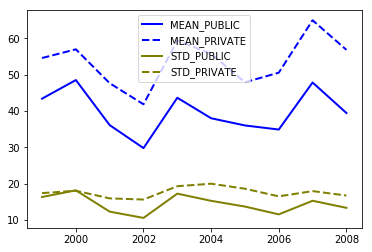

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline

mean_std_o.reset_index(inplace=True)
mean_std_o['YEAR'] = mean_std_o['YEAR'].astype(int)
plt.plot('YEAR', 'MEAN_PUBLIC', data=mean_std_o, marker='', color='blue', linewidth=2)
plt.plot('YEAR', 'MEAN_PRIVATE', data=mean_std_o, marker='', color='blue', linewidth=2, linestyle='dashed')
plt.plot('YEAR', 'STD_PUBLIC', data=mean_std_o, marker='', color='olive', linewidth=2)
plt.plot('YEAR', 'STD_PRIVATE', data=mean_std_o, marker='', color='olive', linewidth=2, linestyle='dashed')

plt.legend()

We can observe in this analysis that the scores of the public and private schools have the same "drawing" and are spaced in a more or less constant form. To check this phenomenon, let's construct a column of difference between the notes and plot your chart:



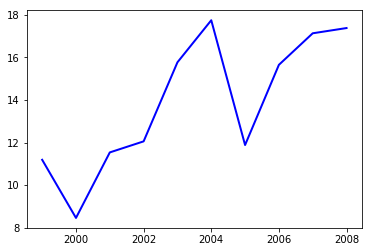

In [9]:
mean_std_o['DIFF'] = mean_std_o['MEAN_PRIVATE'] - mean_std_o['MEAN_PUBLIC']
plt.plot('YEAR', 'DIFF', data=mean_std_o, marker='', color='blue', linewidth=2)

In [10]:
mean_std_o['DIFF'].max()

17.75072733327714

In [11]:
mean_std_o['DIFF'].min()

8.457552896753057

Now, let's do the same to essay scores:

In [12]:
ppe_mean = enem.groupby(['YEAR', 'SECONDARY_SCHOOL_2']).mean()['ESSAY_SCORE']
ppe_mean_public = ppe_mean.loc[ppe_mean.index.get_level_values('SECONDARY_SCHOOL_2') == 'public'].xs('public', level=1)
ppe_mean_private = ppe_mean.loc[ppe_mean.index.get_level_values('SECONDARY_SCHOOL_2') == 'private'].xs('private', level=1)

In [13]:
ppe_std = enem.groupby(['YEAR', 'SECONDARY_SCHOOL_2']).std()['ESSAY_SCORE']
ppe_std_public = ppe_std.loc[ppe_std.index.get_level_values('SECONDARY_SCHOOL_2') == 'public'].xs('public', level=1)
ppe_std_private = ppe_std.loc[ppe_std.index.get_level_values('SECONDARY_SCHOOL_2') == 'private'].xs('private', level=1)

In [14]:
mean_std_e = pd.DataFrame(
    {'MEAN_PUBLIC': ppe_mean_public, 'MEAN_PRIVATE':ppe_mean_private, 
     'STD_PUBLIC': ppe_std_public, 'STD_PRIVATE':ppe_std_private}
)
mean_std_e

,MEAN_PUBLIC,MEAN_PRIVATE,STD_PUBLIC,STD_PRIVATE
YEAR,,,,
1999,41.852936,48.580293,22.561681,23.061552
2000,54.001700,55.296372,21.649851,23.545837
2001,47.766693,53.629413,17.814134,20.693039
2002,49.055042,54.059500,17.958081,21.969717
2003,47.585288,51.420263,20.764072,25.985926
2004,36.974702,48.505747,25.484605,27.964092
2005,52.939522,53.942982,17.537182,22.814929
2006,50.389122,54.215586,19.040550,22.969008
2007,53.769430,60.500689,15.593211,16.558895


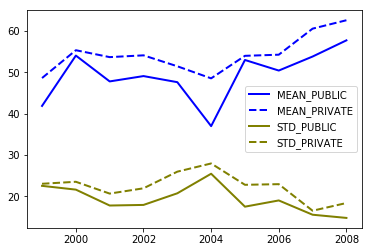

In [15]:
mean_std_e.reset_index(inplace=True)
mean_std_e['YEAR'] = mean_std_e['YEAR'].astype(int)
plt.plot('YEAR', 'MEAN_PUBLIC', data=mean_std_e, marker='', color='blue', linewidth=2)
plt.plot('YEAR', 'MEAN_PRIVATE', data=mean_std_e, marker='', color='blue', linewidth=2, linestyle='dashed')
plt.plot('YEAR', 'STD_PUBLIC', data=mean_std_e, marker='', color='olive', linewidth=2)
plt.plot('YEAR', 'STD_PRIVATE', data=mean_std_e, marker='', color='olive', linewidth=2, linestyle='dashed')

plt.legend()

It was noted that the behavior of the private school grades was higher, but there were large differences between the differences in school grades, noting the great difference in 2004, with a high standard deviation, both for public schools and individuals.

### Difference of notes regarding infrastructure and basic sanitation

Let's compare now, using the same data, two different extracts: students living in homes with tap water and electricity and students who do not have tap water and electricity at home.

First let's bring together all the students who have both resources:

In [16]:
we_mean = enem.groupby(['YEAR', 'TAP_WATER', 'ELECTRIFIED_HOME']).mean()['MC_SCORE']
we_mean_both = we_mean.loc[
    (we_mean.index.get_level_values('TAP_WATER') == 'yes') & 
    (we_mean.index.get_level_values('ELECTRIFIED_HOME') == 'yes')
].xs('yes', level=2).xs('yes', level=1)

In [17]:
we_mean_none = we_mean.loc[
    (we_mean.index.get_level_values('TAP_WATER') == 'no') & 
    (we_mean.index.get_level_values('ELECTRIFIED_HOME') == 'no')
].xs('no', level=2).xs('no', level=1)


In [18]:
we_mean_df = pd.DataFrame(
    {'MEAN_BOTH': we_mean_both, 'MEAN_NONE':we_mean_none}
)
we_mean_df

,MEAN_BOTH,MEAN_NONE
YEAR,,
1999,47.110741,44.661204
2000,51.184570,49.398145
2001,37.817669,32.638472
2002,31.409227,26.360778
2003,46.227707,39.414856
2004,40.470997,34.972897
2005,37.043010,30.969300
2006,37.274898,30.088836
2007,49.812652,41.459613


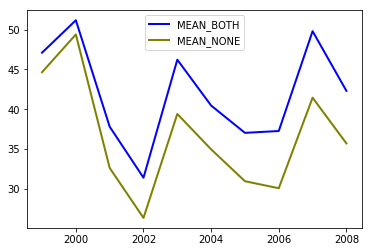

In [19]:
we_mean_df.reset_index(inplace=True)
we_mean_df['YEAR'] = we_mean_df['YEAR'].astype(int)
plt.plot('YEAR', 'MEAN_BOTH', data=we_mean_df, marker='', color='blue', linewidth=2)
plt.plot('YEAR', 'MEAN_NONE', data=we_mean_df, marker='', color='olive', linewidth=2)

plt.legend()

### Difference in relation to total family income

Another interesting analysis is to measure the average grade as a function of total family income. The total monthly family income was organized into 8 bands: 1 minimum wage or less; 1 to 2 minimum wages; 2 to 5 minimum wages; 5 to 10 minimum wages; 10 to 30 minimum wages; 30 to 50 minimum wages; more than 50 minimum wages; and no monthly income:

In [20]:
inc_mean = enem.groupby(['YEAR', 'FAMILY_INCOME']).mean()['MC_SCORE']
inc_mean_A = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'A_1_MW_or_less'].xs('A_1_MW_or_less', level=1)
inc_mean_B = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'B_1_to_2_MW'].xs('B_1_to_2_MW', level=1)
inc_mean_C = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'C_2_to_5_MW'].xs('C_2_to_5_MW', level=1)
inc_mean_D = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'D_5_to_10_MW'].xs('D_5_to_10_MW', level=1)
inc_mean_E = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'E_10_to_30_MW'].xs('E_10_to_30_MW', level=1)
inc_mean_F = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'F_30_to_50_MW'].xs('F_30_to_50_MW', level=1)
inc_mean_G = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'G_50+_MW'].xs('G_50+_MW', level=1)
inc_mean_H = inc_mean.loc[inc_mean.index.get_level_values('FAMILY_INCOME') == 'H_no_income'].xs('H_no_income', level=1)
inc_mean_df = pd.DataFrame(
    {'A_1_MW_or_less': inc_mean_A, 'B_1_to_2_MW':inc_mean_B, 
     'C_2_to_5_MW': inc_mean_C, 'D_5_to_10_MW':inc_mean_D, 
     'E_10_to_30_MW': inc_mean_E, 'F_30_to_50_MW':inc_mean_F, 
     'G_50+_MW': inc_mean_G, 'H_no_income':inc_mean_H}
)
inc_mean_df

,A_1_MW_or_less,B_1_to_2_MW,C_2_to_5_MW,D_5_to_10_MW,E_10_to_30_MW,F_30_to_50_MW,G_50+_MW,H_no_income
YEAR,,,,,,,,
1999,33.968140,36.554268,41.410276,47.226818,53.802565,57.881187,58.774203,44.168856
2000,36.457261,38.041872,45.433937,51.942112,57.945445,61.018604,59.859634,45.967342
2001,30.640216,33.341829,37.314053,41.008144,46.642202,50.436142,50.938898,32.347530
2002,25.951000,27.887710,31.288648,34.886380,40.368790,43.573502,44.366829,26.640386
2003,34.953358,40.429991,48.886515,55.077630,61.693604,63.260614,57.220432,35.175571
2004,31.229182,35.502523,42.161082,47.785604,54.412509,54.241201,50.907652,32.105335
2005,30.073298,34.296858,39.887689,44.139720,50.406092,47.345833,46.940305,28.725878
2006,30.929945,34.203323,38.757741,44.976785,54.519120,57.727555,52.297337,30.517723
2007,42.222302,47.263009,53.712815,59.654524,69.200712,71.510000,59.477701,39.718785


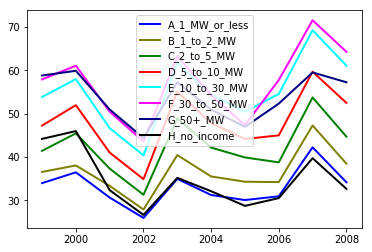

In [21]:
df_tmp = inc_mean_df.reset_index()
df_tmp['YEAR'] = df_tmp['YEAR'].astype(int)

plt.plot('YEAR', 'A_1_MW_or_less', data=df_tmp, marker='', color='blue', linewidth=2)
plt.plot('YEAR', 'B_1_to_2_MW', data=df_tmp, marker='', color='olive', linewidth=2)
plt.plot('YEAR', 'C_2_to_5_MW', data=df_tmp, marker='', color='green', linewidth=2)
plt.plot('YEAR', 'D_5_to_10_MW', data=df_tmp, marker='', color='red', linewidth=2)
plt.plot('YEAR', 'E_10_to_30_MW', data=df_tmp, marker='', color='cyan', linewidth=2)
plt.plot('YEAR', 'F_30_to_50_MW', data=df_tmp, marker='', color='magenta', linewidth=2)
plt.plot('YEAR', 'G_50+_MW', data=df_tmp, marker='', color='navy', linewidth=2)
plt.plot('YEAR', 'H_no_income', data=df_tmp, marker='', color='black', linewidth=2)
plt.legend()

## Difference regarding preparatory course
Another aspect to consider is to verify if the candidate attended a preparatory course in the year of the exam:

In [111]:
pc_mean = enem.groupby(['YEAR', 'CURRENTY_PREP_COURSE']).mean()['MC_SCORE']
pc_mean_yes = pc_mean.loc[
    pc_mean.index.get_level_values('CURRENTY_PREP_COURSE') == 'yes'
].xs('yes', level=1)

In [112]:
pc_mean_no = pc_mean.loc[
    pc_mean.index.get_level_values('CURRENTY_PREP_COURSE') == 'no'
].xs('no', level=1)

In [113]:
pc_mean_df = pd.DataFrame(
    {'yes': pc_mean_yes, 'no':pc_mean_no}
)
pc_mean_df

,yes,no
YEAR,,
1999,45.997518,44.521377
2000,53.784133,43.348239
2001,37.014521,39.725550
2002,35.805411,30.407299
2003,52.035079,41.015679
2004,47.733150,36.108457
2005,40.516131,35.455183
2006,42.039371,35.327378
2007,51.622581,48.243659


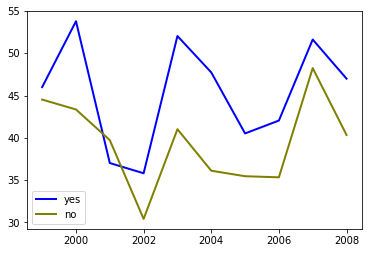

In [114]:
pc_mean_df.reset_index(inplace=True)
pc_mean_df['YEAR'] = pc_mean_df['YEAR'].astype(int)
plt.plot('YEAR', 'yes', data=pc_mean_df, marker='', color='blue', linewidth=2)
plt.plot('YEAR', 'no', data=pc_mean_df, marker='', color='olive', linewidth=2)
plt.legend()

### Comparing income bands and performance of students in public and private schools

An interesting thing to do is to calculate how many students, within your monthly income band, are in public or private school, and how many of these are above the average of your own range.

First we count how many students have each income band in each year:

In [35]:
qty_per_year = enem.groupby(['YEAR', 'FAMILY_INCOME', 'SECONDARY_SCHOOL_2']).count()['MC_SCORE']
qty_priv_per_year = qty_per_year.loc[qty_per_year.index.\
    get_level_values('SECONDARY_SCHOOL_2') == 'private'].xs('private', level=2).dropna().astype(int)
qty_priv_per_year = qty_priv_per_year.loc[qty_priv_per_year.index.get_level_values('FAMILY_INCOME') != '*']
qty_priv_per_year = qty_priv_per_year.rename('TOTAL_PRIVATE')

qty_pub_per_year = qty_per_year.loc[qty_per_year.index.\
    get_level_values('SECONDARY_SCHOOL_2') == 'public'].xs('public', level=2).dropna().astype(int)
qty_pub_per_year = qty_pub_per_year.loc[qty_pub_per_year.index.get_level_values('FAMILY_INCOME') != '*']
qty_pub_per_year = qty_pub_per_year.rename('TOTAL_PUBLIC')

YEAR  FAMILY_INCOME 
1999  A_1_MW_or_less     1409
      B_1_to_2_MW        6656
      C_2_to_5_MW       21275
      D_5_to_10_MW      21395
      E_10_to_30_MW     10491
Name: TOTAL_PUBLIC, dtype: int64

Then we take the average score for each income band per year:

In [49]:
inc_mean_per_year = inc_mean_df.stack()
inc_mean_per_year.index.names = ['YEAR', 'FAMILY_INCOME']
inc_mean_per_year = inc_mean_per_year.rename("MEAN_GRADE")
inc_mean_per_year.head()

YEAR  FAMILY_INCOME 
1999  A_1_MW_or_less    33.968140
      B_1_to_2_MW       36.554268
      C_2_to_5_MW       41.410276
      D_5_to_10_MW      47.226818
      E_10_to_30_MW     53.802565
Name: MEAN_GRADE, dtype: float64

Then we count only the students whose score in the multiple choice test was higher than the average of the income band, taking into account whether the school is public or private:

In [45]:
enem_inc_public = enem[enem['SECONDARY_SCHOOL_2'] == 'public'][['YEAR', 'FAMILY_INCOME', 'MC_SCORE']]
enem_inc_public = enem_inc_public.merge(inc_mean_per_year, how='left', on=['YEAR', 'FAMILY_INCOME'])
qty_enem_inc_public = enem_inc_public.loc[enem_inc_public['MC_SCORE'] > enem_inc_public['MEAN_GRADE']].\
    groupby(['YEAR', 'FAMILY_INCOME']).count()['MC_SCORE']
qty_enem_inc_public = qty_enem_inc_public.rename('COUNT_PUBLIC_ABOVE_MEAN')

enem_inc_private = enem[enem['SECONDARY_SCHOOL_2'] == 'private'][['YEAR', 'FAMILY_INCOME', 'MC_SCORE']]
enem_inc_private = enem_inc_private.merge(inc_mean_per_year, how='left', on=['YEAR', 'FAMILY_INCOME'])
qty_enem_inc_private = enem_inc_private.loc[enem_inc_private['MC_SCORE'] > enem_inc_private['MEAN_GRADE']].\
    groupby(['YEAR', 'FAMILY_INCOME']).count()['MC_SCORE']
qty_enem_inc_private = qty_enem_inc_private.rename('COUNT_PRIVATE_ABOVE_MEAN')

qty_enem_inc_public.head()

YEAR  FAMILY_INCOME 
1999  A_1_MW_or_less     537
      B_1_to_2_MW       2537
      C_2_to_5_MW       8527
      D_5_to_10_MW      9096
      E_10_to_30_MW     4589
Name: COUNT_PUBLIC_ABOVE_MEAN, dtype: int64

Now we put them together and show the percentage:

In [25]:
priv_per_year = qty_priv_per_year.to_frame().\
    merge(qty_enem_inc_private, how='left', on=['YEAR', 'FAMILY_INCOME']).dropna()
priv_per_year['COUNT_PRIVATE_ABOVE_MEAN'] = priv_per_year['COUNT_PRIVATE_ABOVE_MEAN'].astype(int)
priv_per_year['PER_PRIV_ABOVE_MEAN'] = (priv_per_year['COUNT_PRIVATE_ABOVE_MEAN'] * 100)/ priv_per_year['TOTAL_PRIVATE']
priv_per_year.head()

TOTAL_PRIVATE  COUNT_PRIVATE_ABOVE_MEAN  \
YEAR FAMILY_INCOME                                             
1999 A_1_MW_or_less            125                        75   
     B_1_to_2_MW               542                       302   
     C_2_to_5_MW              3113                      1801   
     D_5_to_10_MW             7284                      4324   
     E_10_to_30_MW           10617                      6151   

                     PER_PRIV_ABOVE_MEAN  
YEAR FAMILY_INCOME                        
1999 A_1_MW_or_less            60.000000  
     B_1_to_2_MW               55.719557  
     C_2_to_5_MW               57.854160  
     D_5_to_10_MW              59.362987  
     E_10_to_30_MW             57.935387

In [26]:
pub_per_year = qty_pub_per_year.to_frame().\
    merge(qty_enem_inc_public, how='left', on=['YEAR', 'FAMILY_INCOME']).dropna()
pub_per_year['COUNT_PUBLIC_ABOVE_MEAN'] = pub_per_year['COUNT_PUBLIC_ABOVE_MEAN'].astype(int)
pub_per_year['PER_PUB_ABOVE_MEAN'] = (pub_per_year['COUNT_PUBLIC_ABOVE_MEAN'] * 100)/ pub_per_year['TOTAL_PUBLIC']
pub_per_year.head()

TOTAL_PUBLIC  COUNT_PUBLIC_ABOVE_MEAN  PER_PUB_ABOVE_MEAN
YEAR FAMILY_INCOME                                                            
1999 A_1_MW_or_less          1409                      537           38.112136
     B_1_to_2_MW             6656                     2537           38.115986
     C_2_to_5_MW            21275                     8527           40.079906
     D_5_to_10_MW           21395                     9096           42.514606
     E_10_to_30_MW          10491                     4589           43.742255

Let's now take each of the income bands and show the proportion of candidates each year by school type:

In [27]:
mean_per_year = pd.DataFrame()
mean_per_year['PER_PUB_ABOVE_MEAN'] = pub_per_year['PER_PUB_ABOVE_MEAN']
mean_per_year['PER_PRIV_ABOVE_MEAN'] = priv_per_year['PER_PRIV_ABOVE_MEAN']

df_A = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'A_1_MW_or_less'].xs('A_1_MW_or_less', level=1)
df_B = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'B_1_to_2_MW'].xs('B_1_to_2_MW', level=1)
df_C = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'C_2_to_5_MW'].xs('C_2_to_5_MW', level=1)
df_D = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'D_5_to_10_MW'].xs('D_5_to_10_MW', level=1)
df_E = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'E_10_to_30_MW'].xs('E_10_to_30_MW', level=1)
df_F = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'F_30_to_50_MW'].xs('F_30_to_50_MW', level=1)
df_G = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'G_50+_MW'].xs('G_50+_MW', level=1)
df_H = mean_per_year.loc[mean_per_year.index.get_level_values('FAMILY_INCOME') == 'H_no_income'].xs('H_no_income', level=1)


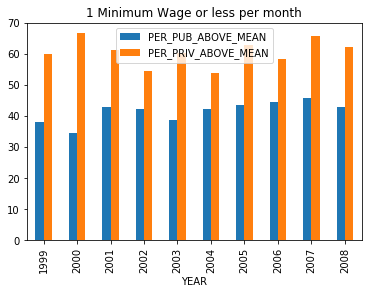

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

df_A.plot(kind='bar', title="1 Minimum Wage or less per month")

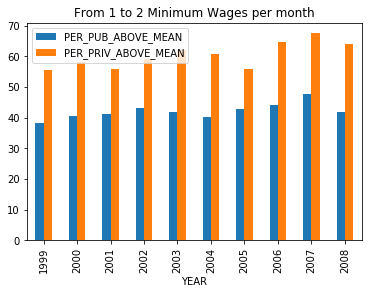

In [29]:
df_B.plot(kind='bar', title="From 1 to 2 Minimum Wages per month")

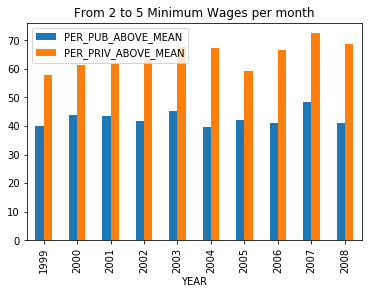

In [30]:
df_C.plot(kind='bar', title="From 2 to 5 Minimum Wages per month")

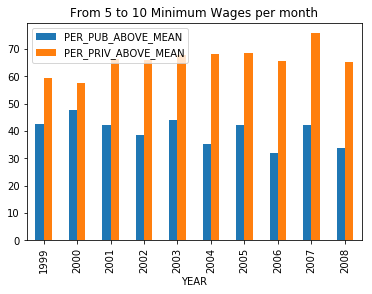

In [31]:
df_D.plot(kind='bar', title="From 5 to 10 Minimum Wages per month")

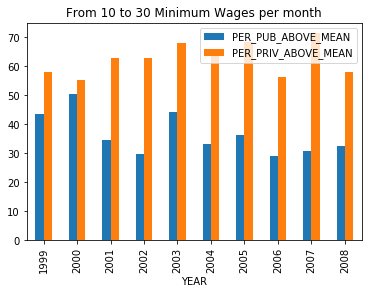

In [32]:
df_E.plot(kind='bar', title="From 10 to 30 Minimum Wages per month")

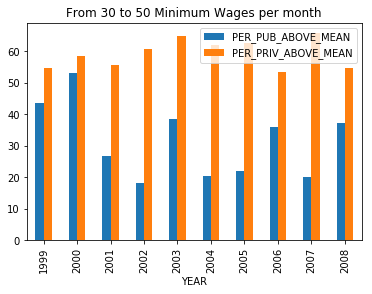

In [33]:
df_F.plot(kind='bar', title="From 30 to 50 Minimum Wages per month")

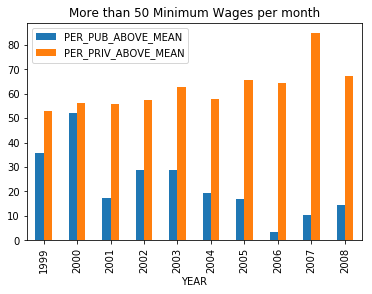

In [34]:
df_G.plot(kind='bar', title="More than 50 Minimum Wages per month")

It is interesting to note that, regardless of the student's income band, proportionately more students from private schools had an objective test score above average.

### Comparing parental schooling and performance of public and private school students

Another interesting thing to do is to use the same methodology to compare the average score of students whose parents have higher education and whose both parents do not have and compare their respective performances above or below average with the fact that they studied in public schools or private.

First we take the average of each year and we group with respect to the two parents have higher education and the two do not have:

In [82]:
mask_parents_education = ((enem['FATHER_SCHOOLING'] == 'G-complete_higher_education') | \
      (enem['FATHER_SCHOOLING'] == 'H-postgraduate')) & \
     ((enem['MOTHER_SCHOOLING'] == 'G-complete_higher_education') | \
      (enem['MOTHER_SCHOOLING'] == 'H-postgraduate'))

mean_education_both = enem[['YEAR', 'MC_SCORE']].loc[mask_parents_education]
mean_education_both = mean_education_both.groupby('YEAR').mean()['MC_SCORE']
mean_education_both = mean_education_both.rename("MEAN_GRADE").to_frame()
mean_education_both['PARENTS_SCHOOLING'] = 'both'

mean_education_none = enem[['YEAR', 'MC_SCORE']].loc[~mask_parents_education]
mean_education_none = mean_education_none.groupby('YEAR').mean()['MC_SCORE']
mean_education_none = mean_education_none.rename("MEAN_GRADE").to_frame()
mean_education_none['PARENTS_SCHOOLING'] = 'none'

mean_education_ps = pd.concat([mean_education_both, mean_education_none])
mean_education_ps.reset_index(inplace=True)
mean_education_ps.sort_values(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
mean_education_ps.set_index(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
mean_education_ps = mean_education_ps.squeeze().rename("MEAN_GRADE")

mean_education_ps.head()

YEAR  PARENTS_SCHOOLING
1999  both                 60.438033
      none                 45.683902
2000  both                 62.987877
      none                 49.936372
2001  both                 53.361863
Name: MEAN_GRADE, dtype: float64

Then we count how many students in each of these bands did public or private school:

In [72]:
qty_both_public_per_year = enem[['YEAR', 'MC_SCORE', 'SECONDARY_SCHOOL_2']].\
    loc[mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'public')].\
    groupby('YEAR').count()['MC_SCORE']
qty_both_public_per_year = qty_both_public_per_year.to_frame()
qty_both_public_per_year['PARENTS_SCHOOLING'] = 'both'
qty_none_public_per_year = enem[['YEAR', 'MC_SCORE', 'SECONDARY_SCHOOL_2']].\
    loc[~mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'public')]\
    .groupby('YEAR').count()['MC_SCORE']
qty_none_public_per_year = qty_none_public_per_year.to_frame()
qty_none_public_per_year['PARENTS_SCHOOLING'] = 'none'
qty_public_per_year_ps = pd.concat([qty_both_public_per_year, qty_none_public_per_year])
qty_public_per_year_ps.reset_index(inplace=True)
qty_public_per_year_ps.sort_values(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
qty_public_per_year_ps.set_index(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
qty_public_per_year_ps = qty_public_per_year_ps.squeeze().rename("TOTAL_PUBLIC")


qty_both_private_per_year = enem[['YEAR', 'MC_SCORE', 'SECONDARY_SCHOOL_2']].\
    loc[mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'private')].\
    groupby('YEAR').count()['MC_SCORE']
qty_both_private_per_year = qty_both_private_per_year.to_frame()
qty_both_private_per_year['PARENTS_SCHOOLING'] = 'both'
qty_none_private_per_year = enem[['YEAR', 'MC_SCORE', 'SECONDARY_SCHOOL_2']].\
    loc[~mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'private')]\
    .groupby('YEAR').count()['MC_SCORE']
qty_none_private_per_year = qty_none_private_per_year.to_frame()
qty_none_private_per_year['PARENTS_SCHOOLING'] = 'none'
qty_private_per_year_ps = pd.concat([qty_both_private_per_year, qty_none_private_per_year])
qty_private_per_year_ps.reset_index(inplace=True)
qty_private_per_year_ps.sort_values(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
qty_private_per_year_ps.set_index(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
qty_private_per_year_ps = qty_private_per_year_ps.squeeze().rename("TOTAL_PRIVATE")


qty_public_per_year_ps.head()

YEAR  PARENTS_SCHOOLING
1999  both                  2004
      none                 60892
2000  both                   950
      none                 24338
2001  both                   798
Name: TOTAL_PUBLIC, dtype: int64

Then we count how many students in each of these bands, taking into account the public or private school, had above average scores:

In [84]:
enem_both_public_ps = enem[['YEAR', 'MC_SCORE']].loc[mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'public')] 
enem_both_public_ps = enem_both_public_ps.merge(mean_education_both, how='left', on=['YEAR'])
enem_both_public_ps = enem_both_public_ps.loc[enem_both_public_ps['MC_SCORE'] > enem_both_public_ps['MEAN_GRADE']].\
    groupby(['YEAR']).count()['MC_SCORE']
enem_both_public_ps = enem_both_public_ps.rename('COUNT_ABOVE')
enem_both_public_ps = enem_both_public_ps.to_frame()
enem_both_public_ps['PARENTS_SCHOOLING'] = 'both'
enem_none_public_ps = enem[['YEAR', 'MC_SCORE']].loc[~mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'public')] 
enem_none_public_ps = enem_none_public_ps.merge(mean_education_none, how='left', on=['YEAR'])
enem_none_public_ps = enem_none_public_ps.loc[enem_none_public_ps['MC_SCORE'] > enem_none_public_ps['MEAN_GRADE']].\
    groupby(['YEAR']).count()['MC_SCORE']
enem_none_public_ps = enem_none_public_ps.rename('COUNT_ABOVE')
enem_none_public_ps = enem_none_public_ps.to_frame()
enem_none_public_ps['PARENTS_SCHOOLING'] = 'none'
above_mean_public_per_year_ps = pd.concat([enem_both_public_ps, enem_none_public_ps])
above_mean_public_per_year_ps.reset_index(inplace=True)
above_mean_public_per_year_ps.sort_values(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
above_mean_public_per_year_ps.set_index(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
above_mean_public_per_year_ps = above_mean_public_per_year_ps.squeeze().rename("COUNT_PUBLIC_ABOVE_MEAN")

enem_both_private_ps = enem[['YEAR', 'MC_SCORE']].loc[mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'private')] 
enem_both_private_ps = enem_both_private_ps.merge(mean_education_both, how='left', on=['YEAR'])
enem_both_private_ps = enem_both_private_ps.loc[enem_both_private_ps['MC_SCORE'] > enem_both_private_ps['MEAN_GRADE']].\
    groupby(['YEAR']).count()['MC_SCORE']
enem_both_private_ps = enem_both_private_ps.rename('COUNT_ABOVE')
enem_both_private_ps = enem_both_private_ps.to_frame()
enem_both_private_ps['PARENTS_SCHOOLING'] = 'both'
enem_none_private_ps = enem[['YEAR', 'MC_SCORE']].loc[~mask_parents_education & (enem['SECONDARY_SCHOOL_2'] == 'private')] 
enem_none_private_ps = enem_none_private_ps.merge(mean_education_none, how='left', on=['YEAR'])
enem_none_private_ps = enem_none_private_ps.loc[enem_none_private_ps['MC_SCORE'] > enem_none_private_ps['MEAN_GRADE']].\
    groupby(['YEAR']).count()['MC_SCORE']
enem_none_private_ps = enem_none_private_ps.rename('COUNT_ABOVE')
enem_none_private_ps = enem_none_private_ps.to_frame()
enem_none_private_ps['PARENTS_SCHOOLING'] = 'none'
above_mean_private_per_year_ps = pd.concat([enem_both_private_ps, enem_none_private_ps])
above_mean_private_per_year_ps.reset_index(inplace=True)
above_mean_private_per_year_ps.sort_values(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
above_mean_private_per_year_ps.set_index(['YEAR', 'PARENTS_SCHOOLING'], inplace=True)
above_mean_private_per_year_ps = above_mean_private_per_year_ps.squeeze().rename("COUNT_PRIVATE_ABOVE_MEAN")


Now we put it all together to get the percentage:

In [98]:
pub_per_year = qty_public_per_year_ps.to_frame().\
    merge(above_mean_public_per_year_ps, how='left', on=['YEAR', 'PARENTS_SCHOOLING']).dropna()
pub_per_year['PER_PUB_ABOVE_MEAN'] = (pub_per_year['COUNT_PUBLIC_ABOVE_MEAN'] * 100)/ pub_per_year['TOTAL_PUBLIC']


priv_per_year = qty_private_per_year_ps.to_frame().\
    merge(above_mean_private_per_year_ps, how='left', on=['YEAR', 'PARENTS_SCHOOLING']).dropna()
priv_per_year['PER_PRIV_ABOVE_MEAN'] = (priv_per_year['COUNT_PRIVATE_ABOVE_MEAN'] * 100)/ priv_per_year['TOTAL_PRIVATE']
pub_per_year.head()

TOTAL_PUBLIC  COUNT_PUBLIC_ABOVE_MEAN  \
YEAR PARENTS_SCHOOLING                                          
1999 both                       2004                      918   
     none                      60892                    24037   
2000 both                        950                      526   
     none                      24338                    10678   
2001 both                        798                      283   

                        PER_PUB_ABOVE_MEAN  
YEAR PARENTS_SCHOOLING                      
1999 both                        45.808383  
     none                        39.474808  
2000 both                        55.368421  
     none                        43.873778  
2001 both                        35.463659

And finally we put it all together in a DataFrame and we plot the percentage of private and public school students who had above average scores taking into account the parents' schooling situation:

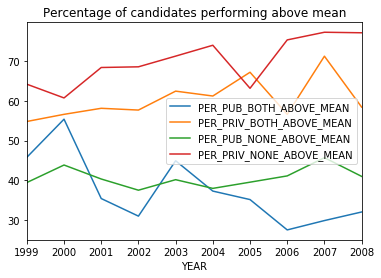

In [110]:
mean_per_year = pd.DataFrame()
mean_per_year['PER_PUB_BOTH_ABOVE_MEAN'] = pub_per_year['PER_PUB_ABOVE_MEAN'].\
    loc[pub_per_year.index.get_level_values('PARENTS_SCHOOLING') == 'both'].xs('both', level=1)
mean_per_year['PER_PRIV_BOTH_ABOVE_MEAN'] = priv_per_year['PER_PRIV_ABOVE_MEAN'].\
    loc[priv_per_year.index.get_level_values('PARENTS_SCHOOLING') == 'both'].xs('both', level=1)
mean_per_year['PER_PUB_NONE_ABOVE_MEAN'] = pub_per_year['PER_PUB_ABOVE_MEAN'].\
    loc[pub_per_year.index.get_level_values('PARENTS_SCHOOLING') == 'none'].xs('none', level=1)
mean_per_year['PER_PRIV_NONE_ABOVE_MEAN'] = priv_per_year['PER_PRIV_ABOVE_MEAN'].\
    loc[priv_per_year.index.get_level_values('PARENTS_SCHOOLING') == 'none'].xs('none', level=1)

mean_per_year.\
    plot(title="Percentage of candidates performing above mean")

## Conclusion and further proposals

The data presented were very useful to show correlations between the notes and the socio-economic situation of the candidates. The average grade of students was expected to grow along with the monthly family income range, as well as we expected that the scores of those who studied in private high school were higher than the grade of those who studied in public schools, as well as we expected a correlation between a better note and water and light infrastructure. What we did not expect is such a low proportion of public school students whose parents have tertiary education who scored above average.

We also conclude that the Pandas tool is very useful for making data inferences. The difficult part was to consolidate and normalize the data so that the data of every year could have the same treatment.

Other studies that we suggest for those who are interested:

* Study data after 2008

* Look for other correlations, such as readings and editorial note

* Expand metadata table to load more data

Any contribution to this study is welcome! You can make a push request and submit changes at any time to the https://github.com/lucasbracher/enem repository.
